# 온실 환경 데이터 예측 파이프라인 (학습/EDA)

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

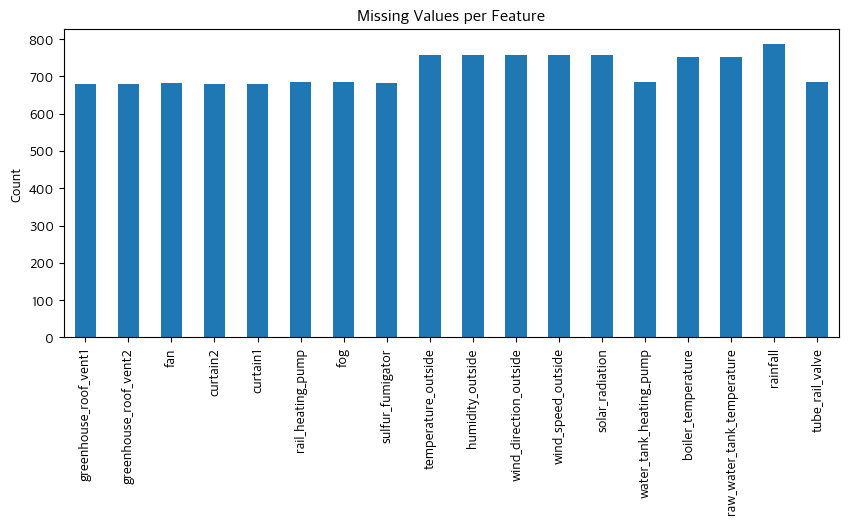

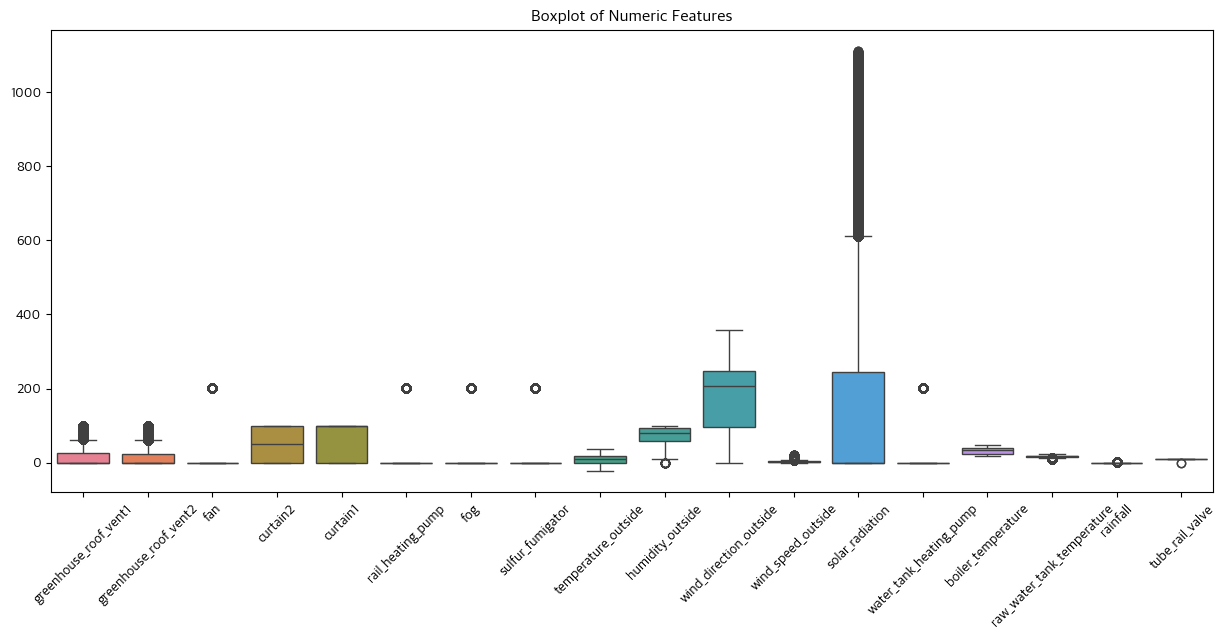

In [26]:
# 데이터 로드 및 EDA
train = pd.read_csv('train_X.csv')
test = pd.read_csv('test_X.csv')
X = pd.concat([train, test], axis=0).sort_index().reset_index(drop=True)
missing = X.isnull().sum()
missing = missing[missing > 0]
if not missing.empty:
    plt.figure(figsize=(10,4))
    missing.plot(kind='bar')
    plt.title('Missing Values per Feature')
    plt.ylabel('Count')
    plt.show()
num_cols = X.select_dtypes(include='number').columns
plt.figure(figsize=(15,6))
sns.boxplot(data=X[num_cols])
plt.title('Boxplot of Numeric Features')
plt.xticks(rotation=45)
plt.show()

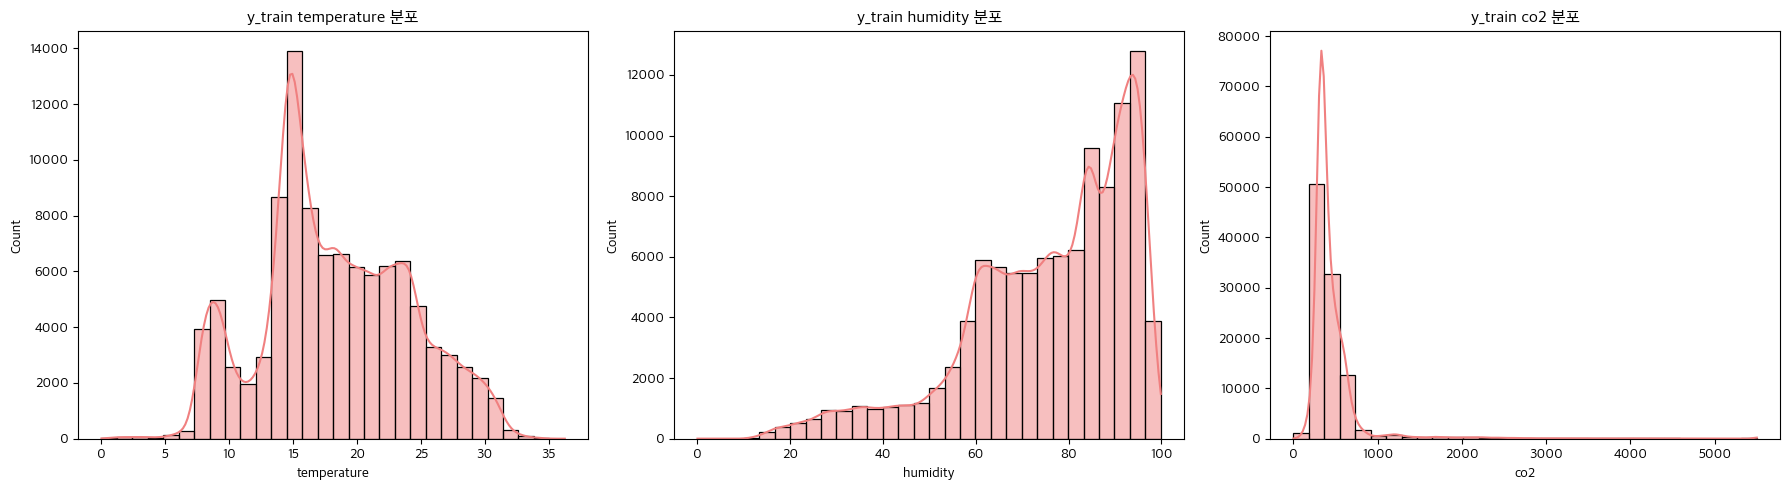

In [27]:
# y_train 분포 시각화
train_y = pd.read_csv('train_y.csv')
plt.figure(figsize=(18, 5))
for i, col in enumerate(['temperature', 'humidity', 'co2']):
    plt.subplot(1, 3, i+1)
    sns.histplot(train_y[col], kde=True, bins=30, color='lightcoral')
    plt.title(f'y_train {col} 분포')
plt.tight_layout()
plt.show()

import joblib

class GreenhousePredictor:
    def __init__(self):
        self.train_X = None
        self.train_y = None
        self.test_X = None
        self.sample_submission = None
        self.models = {}
        self.feature_importance = {}
    def load_data(self):
        print("=== 데이터 로딩 ===")
        self.train_X = pd.read_csv('train_X.csv')
        self.train_y = pd.read_csv('train_y.csv')
        self.test_X = pd.read_csv('test_X.csv')
        self.sample_submission = pd.read_csv('sample_submission.csv')
        for df in [self.train_X, self.train_y, self.test_X, self.sample_submission]:
            df['time'] = pd.to_datetime(df['time'])
        print(f"Train X: {self.train_X.shape}, Train y: {self.train_y.shape}")
        print(f"Test X: {self.test_X.shape}, Submission: {self.sample_submission.shape}")
    def clean_data(self, df):
        df_clean = df.copy()
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            df_clean[col] = df_clean[col].replace([np.inf, -np.inf], np.nan)
            df_clean[col] = df_clean[col].interpolate(method='linear', limit_direction='both')
            df_clean[col] = df_clean[col].fillna(0)
        return df_clean
    def create_time_features(self, df):
        df_new = df.copy()
        df_new['hour'] = df_new['time'].dt.hour
        df_new['day_of_week'] = df_new['time'].dt.dayofweek
        df_new['month'] = df_new['time'].dt.month
        df_new['is_weekend'] = (df_new['time'].dt.dayofweek >= 5).astype(int)
        df_new['hour_sin'] = np.sin(2 * np.pi * df_new['hour'] / 24)
        df_new['hour_cos'] = np.cos(2 * np.pi * df_new['hour'] / 24)
        df_new['month_sin'] = np.sin(2 * np.pi * df_new['month'] / 12)
        df_new['month_cos'] = np.cos(2 * np.pi * df_new['month'] / 12)
        return df_new
    def create_interaction_features(self, df):
        df_new = df.copy()
        interactions = [
            ('temperature_outside', 'humidity_outside', 'temp_humid_interact'),
            ('solar_radiation', 'temperature_outside', 'solar_temp_interact'),
            ('greenhouse_roof_vent1', 'greenhouse_roof_vent2', 'vent_total'),
            ('curtain1', 'curtain2', 'curtain_avg'),
        ]
        for col1, col2, new_name in interactions:
            if col1 in df_new.columns and col2 in df_new.columns:
                if 'total' in new_name:
                    df_new[new_name] = df_new[col1] + df_new[col2]
                elif 'avg' in new_name:
                    df_new[new_name] = (df_new[col1] + df_new[col2]) / 2
                else:
                    df_new[new_name] = df_new[col1] * df_new[col2]
        return df_new
    def prepare_features(self):
        print("\n=== 피쳐 엔지니어링 ===")
        train_clean = self.clean_data(self.train_X)
        train_proc = self.create_time_features(train_clean)
        train_proc = self.create_interaction_features(train_proc)
        test_clean = self.clean_data(self.test_X)
        test_proc = self.create_time_features(test_clean)
        test_proc = self.create_interaction_features(test_proc)
        self.processed_train_X = train_proc
        self.processed_test_X = test_proc
        print(f"Train X 최종 shape: {train_proc.shape}")
        print(f"Test X 최종 shape: {test_proc.shape}")
        return train_proc, test_proc
    def prepare_training_data(self):
        print("\n=== 훈련 데이터 준비 ===")
        merged_data = pd.merge(self.processed_train_X, self.train_y, on='time', how='inner')
        feature_cols = [col for col in merged_data.columns if col not in ['time', 'temperature', 'humidity', 'co2']]
        X = merged_data[feature_cols].copy()
        y = merged_data[['temperature', 'humidity', 'co2']].copy()
        inf_cols = [col for col in X.columns if np.isinf(X[col]).any()]
        for col in inf_cols:
            X[col] = X[col].replace([np.inf, -np.inf], X[col].median())
        X = X.fillna(X.median())
        y = y.fillna(y.median())
        print(f"최종 X shape: {X.shape}, y shape: {y.shape}")
        return X, y, feature_cols
    def train_xgboost_models(self, X, y, feature_cols):
        print("\n=== XGBoost 5-Fold CV 학습 ===")
        xgb_params = {
            'objective': 'reg:squarederror',
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42,
            'n_jobs': -1,
            'tree_method': 'hist'
        }
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        models = {}
        cv_scores = {}
        targets = ['temperature', 'humidity', 'co2']
        for target in targets:
            print(f"\n{target} 모델 학습:")
            target_models, rmse_scores, r2_scores = [], [], []
            for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
                X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
                y_train_fold, y_val_fold = y[target].iloc[train_idx], y[target].iloc[val_idx]
                model = xgb.XGBRegressor(**xgb_params)
                model.fit(X_train_fold, y_train_fold, verbose=False)
                # 모델 저장
                joblib.dump(model, f"model-{target}-{fold}.pkl")
                y_pred = model.predict(X_val_fold)
                rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
                r2 = r2_score(y_val_fold, y_pred)
                rmse_scores.append(rmse)
                r2_scores.append(r2)
                target_models.append(model)
                print(f"  Fold {fold+1}/5 RMSE: {rmse:.4f}, R²: {r2:.4f}")
            models[target] = target_models
            cv_scores[target] = {
                'rmse_mean': np.mean(rmse_scores),
                'rmse_std': np.std(rmse_scores),
                'r2_mean': np.mean(r2_scores),
                'r2_std': np.std(r2_scores)
            }
        self.models = models
        return models, cv_scores
    def run_pipeline(self):
        self.load_data()
        self.prepare_features()
        X, y, feature_cols = self.prepare_training_data()
        models, cv_scores = self.train_xgboost_models(X, y, feature_cols)
        return models, cv_scores


In [28]:
# GreenhousePredictor 클래스 정의 및 학습 파이프라인
class GreenhousePredictor:
    def __init__(self):
        self.train_X = None
        self.train_y = None
        self.test_X = None
        self.sample_submission = None
        self.models = {}
        self.feature_importance = {}
    def load_data(self):
        print("=== 데이터 로딩 ===")
        self.train_X = pd.read_csv('train_X.csv')
        self.train_y = pd.read_csv('train_y.csv')
        self.test_X = pd.read_csv('test_X.csv')
        self.sample_submission = pd.read_csv('sample_submission.csv')
        for df in [self.train_X, self.train_y, self.test_X, self.sample_submission]:
            df['time'] = pd.to_datetime(df['time'])
        print(f"Train X: {self.train_X.shape}, Train y: {self.train_y.shape}")
        print(f"Test X: {self.test_X.shape}, Submission: {self.sample_submission.shape}")
    def clean_data(self, df):
        df_clean = df.copy()
        numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            df_clean[col] = df_clean[col].replace([np.inf, -np.inf], np.nan)
            df_clean[col] = df_clean[col].interpolate(method='linear', limit_direction='both')
            df_clean[col] = df_clean[col].fillna(0)
        return df_clean
    def create_time_features(self, df):
        df_new = df.copy()
        df_new['hour'] = df_new['time'].dt.hour
        df_new['day_of_week'] = df_new['time'].dt.dayofweek
        df_new['month'] = df_new['time'].dt.month
        df_new['is_weekend'] = (df_new['time'].dt.dayofweek >= 5).astype(int)
        df_new['hour_sin'] = np.sin(2 * np.pi * df_new['hour'] / 24)
        df_new['hour_cos'] = np.cos(2 * np.pi * df_new['hour'] / 24)
        df_new['month_sin'] = np.sin(2 * np.pi * df_new['month'] / 12)
        df_new['month_cos'] = np.cos(2 * np.pi * df_new['month'] / 12)
        return df_new
    def create_interaction_features(self, df):
        df_new = df.copy()
        interactions = [
            ('temperature_outside', 'humidity_outside', 'temp_humid_interact'),
            ('solar_radiation', 'temperature_outside', 'solar_temp_interact'),
            ('greenhouse_roof_vent1', 'greenhouse_roof_vent2', 'vent_total'),
            ('curtain1', 'curtain2', 'curtain_avg'),
        ]
        for col1, col2, new_name in interactions:
            if col1 in df_new.columns and col2 in df_new.columns:
                if 'total' in new_name:
                    df_new[new_name] = df_new[col1] + df_new[col2]
                elif 'avg' in new_name:
                    df_new[new_name] = (df_new[col1] + df_new[col2]) / 2
                else:
                    df_new[new_name] = df_new[col1] * df_new[col2]
        return df_new
    def prepare_features(self):
        print("\n=== 피쳐 엔지니어링 ===")
        train_clean = self.clean_data(self.train_X)
        train_proc = self.create_time_features(train_clean)
        train_proc = self.create_interaction_features(train_proc)
        test_clean = self.clean_data(self.test_X)
        test_proc = self.create_time_features(test_clean)
        test_proc = self.create_interaction_features(test_proc)
        self.processed_train_X = train_proc
        self.processed_test_X = test_proc
        print(f"Train X 최종 shape: {train_proc.shape}")
        print(f"Test X 최종 shape: {test_proc.shape}")
        return train_proc, test_proc
    def prepare_training_data(self):
        print("\n=== 훈련 데이터 준비 ===")
        merged_data = pd.merge(self.processed_train_X, self.train_y, on='time', how='inner')
        feature_cols = [col for col in merged_data.columns if col not in ['time', 'temperature', 'humidity', 'co2']]
        X = merged_data[feature_cols].copy()
        y = merged_data[['temperature', 'humidity', 'co2']].copy()
        inf_cols = [col for col in X.columns if np.isinf(X[col]).any()]
        for col in inf_cols:
            X[col] = X[col].replace([np.inf, -np.inf], X[col].median())
        X = X.fillna(X.median())
        y = y.fillna(y.median())
        print(f"최종 X shape: {X.shape}, y shape: {y.shape}")
        return X, y, feature_cols
    def train_xgboost_models(self, X, y, feature_cols):
        import joblib
        print("\n=== XGBoost 5-Fold CV 학습 ===")
        xgb_params = {
            'objective': 'reg:squarederror',
            'max_depth': 6,
            'learning_rate': 0.1,
            'n_estimators': 100,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42,
            'n_jobs': -1,
            'tree_method': 'hist'
        }
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        models = {}
        cv_scores = {}
        targets = ['temperature', 'humidity', 'co2']
        for target in targets:
            print(f"\n{target} 모델 학습:")
            target_models, rmse_scores, r2_scores = [], [], []
            for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
                X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
                y_train_fold, y_val_fold = y[target].iloc[train_idx], y[target].iloc[val_idx]
                model = xgb.XGBRegressor(**xgb_params)
                model.fit(X_train_fold, y_train_fold, verbose=False)
                # 모델 저장
                joblib.dump(model, f"model-{target}-{fold}.pkl")
                y_pred = model.predict(X_val_fold)
                rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
                r2 = r2_score(y_val_fold, y_pred)
                rmse_scores.append(rmse)
                r2_scores.append(r2)
                target_models.append(model)
                print(f"  Fold {fold+1}/5 RMSE: {rmse:.4f}, R²: {r2:.4f}")
            models[target] = target_models
            cv_scores[target] = {
                'rmse_mean': np.mean(rmse_scores),
                'rmse_std': np.std(rmse_scores),
                'r2_mean': np.mean(r2_scores),
                'r2_std': np.std(r2_scores)
            }
        self.models = models
        return models, cv_scores
    def run_pipeline(self):
        self.load_data()
        self.prepare_features()
        X, y, feature_cols = self.prepare_training_data()
        models, cv_scores = self.train_xgboost_models(X, y, feature_cols)
        return models, cv_scores

In [29]:
predictor = GreenhousePredictor()
models, cv_scores = predictor.run_pipeline()

=== 데이터 로딩 ===
Train X: (421451, 19), Train y: (103392, 4)
Test X: (103680, 19), Submission: (20598, 4)

=== 피쳐 엔지니어링 ===
Train X: (421451, 19), Train y: (103392, 4)
Test X: (103680, 19), Submission: (20598, 4)

=== 피쳐 엔지니어링 ===
Train X 최종 shape: (421451, 31)
Test X 최종 shape: (103680, 31)

=== 훈련 데이터 준비 ===
최종 X shape: (84289, 30), y shape: (84289, 3)

=== XGBoost 5-Fold CV 학습 ===

temperature 모델 학습:
  Fold 1/5 RMSE: 0.8240, R²: 0.9813
Train X 최종 shape: (421451, 31)
Test X 최종 shape: (103680, 31)

=== 훈련 데이터 준비 ===
최종 X shape: (84289, 30), y shape: (84289, 3)

=== XGBoost 5-Fold CV 학습 ===

temperature 모델 학습:
  Fold 1/5 RMSE: 0.8240, R²: 0.9813
  Fold 2/5 RMSE: 0.8193, R²: 0.9813
  Fold 3/5 RMSE: 0.8183, R²: 0.9815
  Fold 2/5 RMSE: 0.8193, R²: 0.9813
  Fold 3/5 RMSE: 0.8183, R²: 0.9815
  Fold 4/5 RMSE: 0.8401, R²: 0.9808
  Fold 5/5 RMSE: 0.8121, R²: 0.9819

humidity 모델 학습:
  Fold 4/5 RMSE: 0.8401, R²: 0.9808
  Fold 5/5 RMSE: 0.8121, R²: 0.9819

humidity 모델 학습:
  Fold 1/5 RMSE: 2.9701, R²